
# 📚 Introduction


Ce notebook présente un prototype de classification binaire de radios thoraciques pour le diagnostic de la pneumonie, basé sur le transfert d’apprentissage avec le modèle ResNet pré-entraîné. Le suivi des expérimentations est assuré avec MLflow pour initier une démarche MLOps.

ResNet (Residual Network) introduit le concept de **connexions résiduelles** ou "skip connections", qui 
permettent de **sauter une ou plusieurs couches** pendant l’entraînement.

- ResNet50 contient 50 couches profondes.
- Ces connexions permettent d’**éviter le problème de dégradation** dans les réseaux très profonds (où les 
performances empirent à mesure que le réseau s'approfondit).
- Très robuste et utilisé comme **standard dans les applications industrielles et médicales**.

**Avantages clés :**
- Permet des réseaux très profonds sans perte de performance.
- Très bon compromis entre performance et complexité.
- Architecture éprouvée dans des contextes réels.




# 1️⃣ Import des librairies


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import mlflow
import mlflow.tensorflow
from sklearn.metrics import roc_curve, auc


# 2️⃣ Préparation des données


In [ ]:
# PARAMÈTRES GÉNÉRAUX
img_size = (224, 224)           # Taille standard pour les modèles ImageNet
batch_size = 32
epochs = 5
learning_rate = 1e-4

# CHEMINS VERS LE DATASET
data_dir = 'data/chest_xray'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'test')
test_dir = os.path.join(data_dir, 'val')

# Données d'entraînement avec augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

# Données de validation et test sans augmentation
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Générateurs d'images
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Important pour conserver l'ordre des prédictions
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.



# 3️⃣ Construction du modèle ResNet50 avec transfert d’apprentissage


In [3]:
# Chargement du modèle pré-entraîné sans la top layer (couche de classification originale)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Gel des poids de ResNet pour ne pas l'entraîner à nouveau (transfert learning)
for layer in base_model.layers:
    layer.trainable = False

# Ajout de notre propre "tête" de classification
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)  # Pour réduire le surapprentissage
output = Dense(1, activation='sigmoid')(x)  # Sortie binaire (pneumonie ou pas)
model = Model(inputs=base_model.input, outputs=output)

# Compilation du modèle
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])


# 4️⃣ Entraînement du modèle avec MLflow


In [4]:
# TRACKING MLFLOW 
mlflow.set_experiment("Chest_Xray_Classification_ResNet50")
mlflow.tensorflow.autolog()  # Active le tracking auto des métriques, courbes, etc.

with mlflow.start_run(run_name="ResNet50")as run:
    print("Run ID:", run.info.run_id)

    # Log manuel des paramètres
    mlflow.log_params({
        "model": "ResNet50",
        "batch_size": batch_size,
        "img_size": img_size,
        "learning_rate": learning_rate,
        "epochs": epochs
    })

    # ENTRAÎNEMENT
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs
    )


Run ID: e0a7eca717df42d4832df6ace8d05401


2025/05/28 11:09:33 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.
2025/05/28 11:09:33 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.
c:\Users\adjah\Desktop\CNN\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6453 - loss: 0.7005

163/163 ━━━━━━━━━━━━━━━━━━━━ 364s 2s/step - accuracy: 0.6456 - loss: 0.7001 - val_accuracy: 0.6250 - val_loss: 0.6588
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 312s 2s/step - accuracy: 0.7490 - loss: 0.5671 - val_accuracy: 0.6250 - val_loss: 0.6645
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7451 - loss: 0.5461

163/163 ━━━━━━━━━━━━━━━━━━━━ 435s 3s/step - accuracy: 0.7451 - loss: 0.5461 - val_accuracy: 0.6250 - val_loss: 0.6201
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 437s 3s/step - accuracy: 0.7471 - loss: 0.5228 - val_accuracy: 0.6250 - val_loss: 0.6239
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7465 - loss: 0.5078

163/163 ━━━━━━━━━━━━━━━━━━━━ 359s 2s/step - accuracy: 0.7465 - loss: 0.5078 - val_accuracy: 0.6298 - val_loss: 0.6015


2025/05/28 11:41:25 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: '>=' not supported between instances of 'slice' and 'int'
2025/05/28 11:41:25 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/05/28 11:41:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [5]:
# Fine-tuning - dégel léger
for layer in base_model.layers[-3:]:
    layer.trainable = True

# Recompilation avec un learning rate très faible
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Réentraîner sur 4 époques
fine_tune_epochs = 4
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=fine_tune_epochs
)


2025/05/28 11:42:00 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '494e449144b248dc81aad78c27829dc1', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2025/05/28 11:42:01 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.
2025/05/28 11:42:01 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.


Epoch 1/4
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3639 - loss: 0.9185

163/163 ━━━━━━━━━━━━━━━━━━━━ 359s 2s/step - accuracy: 0.3650 - loss: 0.9175 - val_accuracy: 0.6346 - val_loss: 0.5952
Epoch 2/4
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7893 - loss: 0.4971

163/163 ━━━━━━━━━━━━━━━━━━━━ 292s 2s/step - accuracy: 0.7893 - loss: 0.4970 - val_accuracy: 0.6907 - val_loss: 0.5615
Epoch 3/4
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7769 - loss: 0.4652

163/163 ━━━━━━━━━━━━━━━━━━━━ 334s 2s/step - accuracy: 0.7768 - loss: 0.4652 - val_accuracy: 0.6955 - val_loss: 0.5495
Epoch 4/4
163/163 ━━━━━━━━━━━━━━━━━━━━ 367s 2s/step - accuracy: 0.7798 - loss: 0.4626 - val_accuracy: 0.6907 - val_loss: 0.5506


2025/05/28 12:04:34 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: '>=' not supported between instances of 'slice' and 'int'
2025/05/28 12:04:34 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/05/28 12:04:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



# 5️⃣ Évaluation du modèle


c:\Users\adjah\Desktop\CNN\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step - accuracy: 0.5625 - loss: 0.7245
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


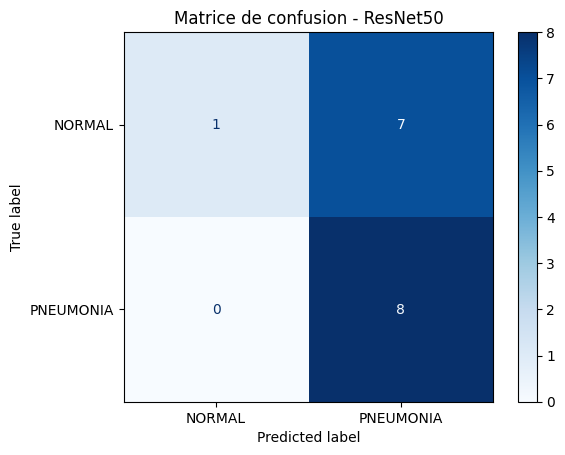

In [6]:
# ÉVALUATION TEST
test_loss, test_acc = model.evaluate(test_generator)
mlflow.log_metric("test_accuracy", test_acc)
mlflow.log_metric("test_loss", test_loss)

# MATRICE DE CONFUSION
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(test_generator.class_indices.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion - ResNet50")
plt.savefig("confusion_matrix_resnet50.png")
mlflow.log_artifact("confusion_matrix_resnet50.png")
plt.show()


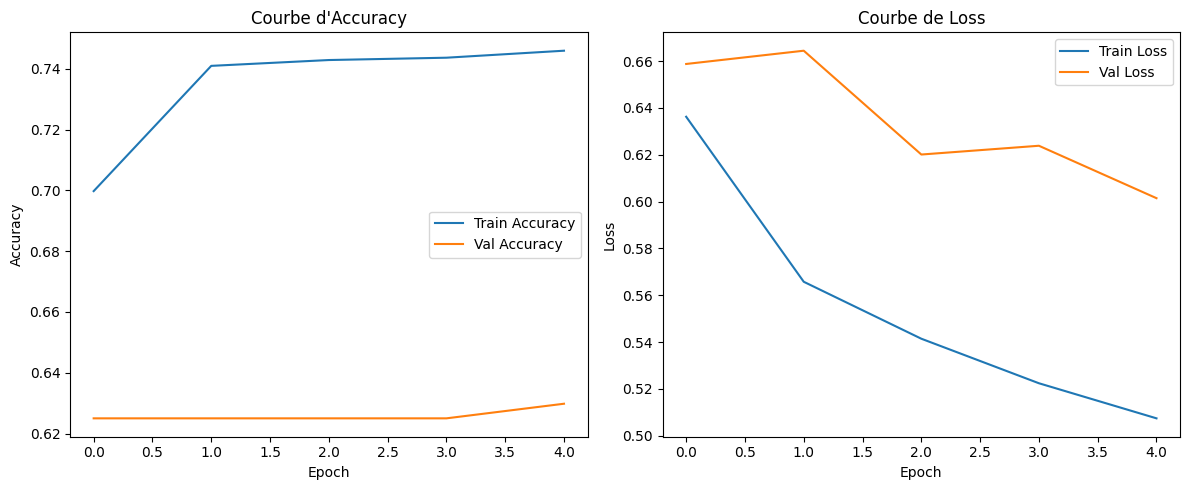

In [9]:
# Affichage des courbes d'accuracy et de loss pour l'entraînement et la validation
plt.figure(figsize=(12, 5))

# Courbe d'accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Courbe d'Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Courbe de loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Courbe de Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

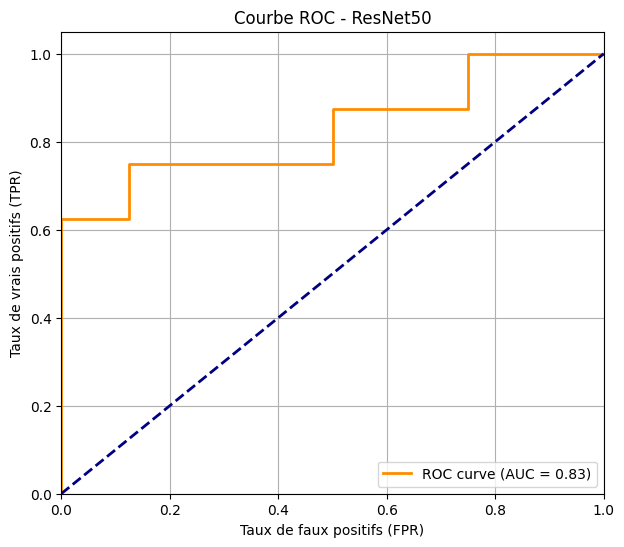

In [10]:
# Génération de la courbe ROC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC - ResNet50')
plt.legend(loc="lower right")
plt.grid()
plt.show()

📉 La courbe ROC montre des sauts nets, ce qui est typique quand on a peu de données ( 16 exemples en validation).

Chaque point représente un changement important dans le taux de vrais positifs (TPR) ou de faux positifs (FPR), ce qui donne une courbe en escalier.

AUC = 0.83 :

Malgré la forme irrégulière, l'AUC reste élevée (0.83), ce qui confirme une bonne capacité à distinguer les deux classes.

Le modèle a tendance à donner des scores plus élevés aux cas de pneumonie qu'aux cas normaux.

Le modèle prédit beaucoup plus la classe "PNEUMONIA", ce qui peut affecter la régularité de la courbe.


# 6️⃣ Sauvegarde et traçabilité du modèle


In [ ]:


model.save("model_resnet50.h5")
mlflow.log_artifact("model_resnet50.h5")



# 7️⃣ Conclusion  

Le modèle ResNet50 présente de bonnes performances en entraînement, mais montre des signes clairs de surapprentissage (overfitting), avec une accuracy de validation faible (~62 %) et une forte confusion entre les classes, en particulier pour la classe "NORMAL". Malgré un AUC de 0.83, indiquant une certaine capacité de discrimination, le modèle ne généralise pas bien. Des ajustements comme l’augmentation de données, la régularisation ou un rééquilibrage des classes sont nécessaires pour améliorer ses performances en validation.
